In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
data_path = "data/html/*.html"

code2convos = dict()
total_code_response_list = []
pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    code_block_count = 0
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})
        convo_texts = []
        last_user_text = None  # Keep track of the last user message

        for i, convo in enumerate(conversations):
            user_div = convo.find("div", attrs={"data-message-author-role": "user"})
            assistant_div = convo.find("div", attrs={"data-message-author-role": "assistant"})

            # When a user message is found, save it to last_user_text
            if user_div:
                last_user_text = user_div.text.strip()
            if assistant_div and assistant_div.find("code"):  # This assumes that <code> tags are used for code blocks
                code_block_count += 1

            # When an assistant message follows a user message, pair them
            if assistant_div and last_user_text is not None:
                convo_texts.append({
                    "role": "user",
                    "text": last_user_text,
                    "response": assistant_div.text.strip()  # Pair with the last user message
                })
                last_user_text = None  # Reset last_user_text after pairing
        total_code_response_list.append((file_code, code_block_count))
        
        code2convos[file_code] = convo_texts
total_code_response_df = pd.DataFrame(total_code_response_list, columns=['code', 'code_responses'])

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:15<00:00,  8.33it/s]


In [6]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])
pprint(total_code_response_df)
# Check for the presence of a code block


[{'response': 'You can load a CSV file into a Pandas DataFrame in Python using '
              "the pandas.read_csv() function. Here's how you can do it for "
              'your specific CSV file:pythonCopy codeimport pandas as pd\n'
              '\n'
              '# Specify the file path\n'
              "file_path = 'cs412_hw1_dataset.csv'\n"
              '\n'
              '# Load the CSV file into a Pandas DataFrame\n'
              'df = pd.read_csv(file_path)\n'
              '\n'
              '# Display the first few rows of the DataFrame to verify the '
              'data has been loaded\n'
              'print(df.head())\n'
              "This code assumes that the CSV file 'cs412_hw1_dataset.csv' is "
              'in the same directory as your Python script or Jupyter '
              'Notebook. If the file is in a different directory, you can '
              'specify the full path to the file in the file_path variable.The '
              'pd.read_csv() function will a

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [11]:
prompts = []
responses = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            responses.append(conv["response"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts      

In [8]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'."

In [9]:
questions = [
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Original stop words from scikit-learn
original_stop_words = text.ENGLISH_STOP_WORDS


# Combine original and additional stop words into a list
combined_stop_words = list(original_stop_words)

# Token pattern that matches words with English letters only (no numbers)
# This pattern will match words that consist of two or more English letters
token_pattern = r'(?u)\b[A-Za-z]{2,}\b'

vectorizer = TfidfVectorizer(
    lowercase=True,                  # Convert all characters to lowercase
    stop_words=combined_stop_words,  # Combined stop words
    token_pattern=token_pattern,     # Custom token pattern for English letters only
)

# Fit and transform the data
vectorizer.fit(prompts + questions)
features = vectorizer.get_feature_names_out()

# Now the features should exclude non-English characters and numbers



In [13]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF

,abc,abcseries,ability,abiout,able,abs,absolute,accept,acceptable,accesing,...,youre,youve,ypred,yticklabels,yticks,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
# Download stopwords set
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()
# Define a preprocessing function
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # Lemmatization and stop words removal
    text = ' '.join([
        lemmatizer.lemmatize(word) for word in text.split() 
        if word not in stopwords.words('english')
    ])
    # Tokenize the text
    words = text.split()

    # Only keep words that are spelled correctly
    words = [word for word in words if word in spell or not spell.unknown([word])]

    # Rejoin into a single string
    text = ' '.join(words)
    return text

# Preprocess each prompt and question
processed_prompts = [preprocess_text(prompt) for prompt in prompts]
processed_questions = [preprocess_text(question) for question in questions]

# Fit the vectorizer on the processed text with a strict token pattern
token_pattern = r'\b[a-zA-Z]{2,}\b'  # Only English alphabetic characters
vectorizer = TfidfVectorizer(lowercase=True, token_pattern=token_pattern)

vectorizer.fit(processed_prompts + processed_questions)
features = vectorizer.get_feature_names_out()

# Transform the questions and convert to DataFrame
questions_TF_IDF = pd.DataFrame(
    vectorizer.transform(processed_questions).toarray(), 
    columns=features
)

# Manual filtering of non-English features
english_feature_columns = [col for col in questions_TF_IDF.columns if re.fullmatch(r'[a-zA-Z]+', col)]
questions_TF_IDF = questions_TF_IDF[english_feature_columns]
questions_TF_IDF

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\irfaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,ability,able,absolute,accept,acceptable,access,accomplished,according,accordingly,account,...,wrong,wrote,yeah,year,yearly,yes,yet,yield,zero,zeroth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
code2prompts_tf_idf = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    # Apply the same preprocessing to user_prompts
    processed_user_prompts = [preprocess_text(prompt) for prompt in user_prompts]

    # Transform preprocessed prompts into TF-IDF matrix
    prompts_TF_IDF = pd.DataFrame(
        vectorizer.transform(processed_user_prompts).toarray(), 
        columns=vectorizer.get_feature_names_out()
    )

    code2prompts_tf_idf[code] = prompts_TF_IDF


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [16]:
code2prompts_tf_idf["0031c86e-81f4-4eef-9e0e-28037abf9883"]

,ability,able,absolute,accept,acceptable,access,accomplished,according,accordingly,account,...,wrong,wrote,yeah,year,yearly,yes,yet,yield,zero,zeroth
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.147995,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [18]:
questions[4]

'Tune Hyperparameters (20 pts)\n* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)\n-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)\n'

In [19]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)


# Define the weights for each question based on their contribution to the overall grade.
weights = [ 5, 15, 5, 10, 20, 15, 20, 10]

# Assuming 'question_mapping_scores' is your DataFrame and it's already loaded.
# Apply the weights to each column (excluding the 'code' column).
for i, weight in enumerate(weights):
    question_mapping_scores[f'Q_{i}'] *= weight

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,1.512788,6.536609,1.498218,4.719384,10.390721,1.040977,2.941465,1.500968
1,0225686d-b825-4cac-8691-3a3a5343df2b,4.025933,11.711408,4.442972,6.128060,19.778232,12.978425,13.511586,7.398353
2,041f950b-c013-409a-a642-cffff60b9d4b,0.822335,7.253650,1.412680,6.620465,5.764888,5.462287,9.157459,2.099878
3,04f91058-d0f8-4324-83b2-19c671f433dc,1.191679,4.358603,1.370156,4.838549,6.586580,1.858390,4.793643,5.331295
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,3.144938,12.023740,3.483249,7.510627,17.205058,9.771592,18.295782,6.037874
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.837512,2.981328,0.972440,1.812653,7.361861,15.000000,19.747111,8.343529
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.385862,4.158578,4.710891,8.099867,16.639458,3.762250,17.273020,7.616351
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,5.000000,15.000000,4.662141,9.178980,18.169567,11.213542,18.694945,6.652278
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,5.000000,15.000000,3.386804,9.709553,16.930498,15.000000,20.000000,7.716541


# Feature Engineering
- Number of prompts that a users asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [20]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy", "Hyperparameter", "Hypothetical features"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        # code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [21]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#hyperparameter,#hypothetical features,prompt_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,32.102124
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,5.991354
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,4.907994
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,2.776954
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,2.0,1.569760


In [22]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
print(scores.head())

codes_below_50 = scores[scores["grade"] < 80]["code"].tolist()
print(codes_below_50)

                                   code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
['6312a21b-c6be-44f9-ad81-46307b339fb6', '6b4e988c-eead-46ff-a35b-b2fd325b2698', '6b4e988c-eead-46ff-a35b-b2fd325b2698', '745ffa9e-f540-488a-b752-a3add11cb30b', 'e8fd2278-1620-432d-81cb-02cac8543456', '42980d53-7bcd-4a36-bf3a-aa43f7417ac5', 'da219169-aacb-48b8-abdc-e25f08ad029e', '0031c86e-81f4-4eef-9e0e-28037abf9883', '5e481e20-f714-4f11-b941-0ef2fd5976d3', 'b24c3a33-2952-4ae4-9f2d-643d8fdbc600']


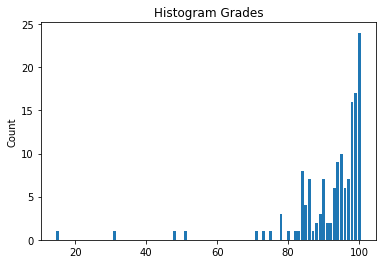

In [23]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()
print()

In [24]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#hyperparameter,#hypothetical features,prompt_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,32.102124
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,5.991354
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,4.907994
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,2.776954
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,2.0,1.569760


In [25]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#hyperparameter,#hypothetical features,prompt_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,32.102124,1.512788,6.536609,1.498218,4.719384,10.390721,1.040977,2.941465,1.500968
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,5.991354,4.025933,11.711408,4.442972,6.128060,19.778232,12.978425,13.511586,7.398353
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,4.907994,0.822335,7.253650,1.412680,6.620465,5.764888,5.462287,9.157459,2.099878
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,2.776954,1.191679,4.358603,1.370156,4.838549,6.586580,1.858390,4.793643,5.331295
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,2.0,1.569760,3.144938,12.023740,3.483249,7.510627,17.205058,9.771592,18.295782,6.037874


#### Merging scores with features

In [26]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df = pd.merge(temp_df, total_code_response_df, on='code', how='left')
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
#temp_df = temp_df[~temp_df['code'].isin(codes_below_50)]
temp_df

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#hyperparameter,#hypothetical features,prompt_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade,code_responses
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,32.102124,1.512788,6.536609,1.498218,4.719384,10.390721,1.040977,2.941465,1.500968,48.0,14
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,5.991354,4.025933,11.711408,4.442972,6.128060,19.778232,12.978425,13.511586,7.398353,99.0,17
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,4.907994,0.822335,7.253650,1.412680,6.620465,5.764888,5.462287,9.157459,2.099878,90.0,7
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,2.776954,1.191679,4.358603,1.370156,4.838549,6.586580,1.858390,4.793643,5.331295,97.0,19
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,2.0,2.0,1.569760,3.144938,12.023740,3.483249,7.510627,17.205058,9.771592,18.295782,6.037874,100.0,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,2.583692,0.837512,2.981328,0.972440,1.812653,7.361861,15.000000,19.747111,8.343529,93.0,16
136,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,1.0,6.0,1.0,3.0,8.580530,0.385862,4.158578,4.710891,8.099867,16.639458,3.762250,17.273020,7.616351,100.0,59
137,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,0.0,4.0,3.0,1.0,10.0,3.177291,5.000000,15.000000,4.662141,9.178980,18.169567,11.213542,18.694945,6.652278,98.0,25
138,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,3.071781,5.000000,15.000000,3.386804,9.709553,16.930498,15.000000,20.000000,7.716541,100.0,14


In [27]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 18) (122,)


#### Train/Test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [29]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [30]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 216.8888888888887
Node 2 has MSE 64.0
Node 3 has MSE 0.0
Node 4 has MSE 0.0
Node 5 has MSE 0.0
Node 6 has MSE 45.800362154819595
Node 7 has MSE 26.246913580247565
Node 8 has MSE 10.639999999999418
Node 9 has MSE 1.0
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 2.66666666666697
Node 13 has MSE 0.0
Node 14 has MSE 1.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 6.977272727272975
Node 18 has MSE 1.3254437869809408
Node 19 has MSE 0.5306122448982933
Node 20 has MSE 0.25
Node 21 has MSE 0.0
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.25
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 0.46913580246928177
Node 28 has MSE 0.1875
Node 29 has MSE 0.0
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 6.770773000667759
Node 33 has MSE 1.9199999999982538
Node 34 has MSE 0.8402366863901989
Node 35 has MSE 0.22222222222080745
Node 36 has MSE 0.0
Node 37 has MSE 0.0
Node 38 has MSE 0.25
Node 39 has MSE 

In [31]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [32]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.0
MSE TEST: 13.6
R2 Train: 1.0
R2 TEST: 0.8788587064960237


## Clustering
### 1) KMeans Clustering
Firstly, we will create an algorithm to find the best value for K. Then, we will use this to plot and analyse the cluster.

C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

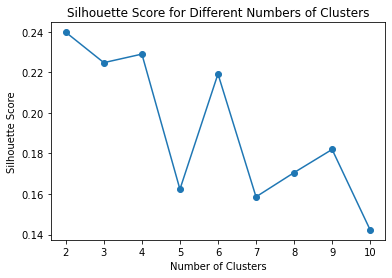

Optimal Number of Clusters: 2


In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def find_optimal_clusters(data, max_clusters=10):

    # Feature scaling 
    # Can possibly try other scaler as well(minmax,etc?)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    silhouette_scores = [] #used to determine optimal number of cluster

    for k in range(2, max_clusters + 1):
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_assignments = kmeans.fit_predict(data_scaled)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data_scaled, cluster_assignments)
        silhouette_scores.append(silhouette_avg)

    # Find the optimal number of clusters with the highest silhouette score
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 because we started with k=2

    return optimal_clusters, silhouette_scores, cluster_assignments

# Selecting relevant features for clustering
# We will include all of the collumns except the identifier, aka the code
X = temp_df[temp_df.columns[1:]].to_numpy()

# Find the optimal number of clusters
optimal_clusters, silhouette_scores, cluster_assignments = find_optimal_clusters(X, max_clusters=10)

# Visualize silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

print(f'Optimal Number of Clusters: {optimal_clusters}')


C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


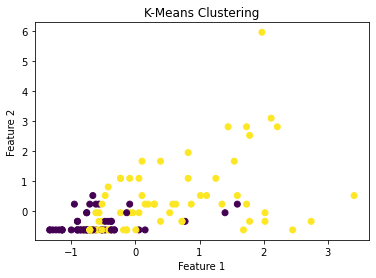

In [44]:
import matplotlib.pyplot as plt

# using the merged df from above
X = temp_df[temp_df.columns[1:]].to_numpy()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# optimal number of cluster
k = 2

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_assignments = kmeans.fit_predict(X_scaled)

# Visualize clusters using scatter plot

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [45]:
# Silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_assignments)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2397843663413637


C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\irfaa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


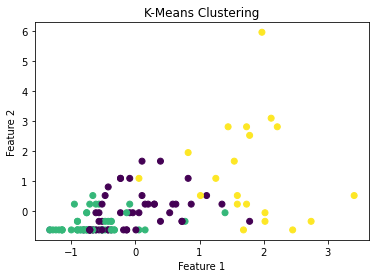

In [46]:
# Choosing the second most optimal
k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_assignments = kmeans.fit_predict(X_scaled)

# Visualize clusters (for example, using a scatter plot)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [47]:
# Silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_assignments)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.22900196465936912


### Conclusion:
The silhouette score from using KMeans is relatively small. It suggests that the clusters have some degree of separation, but there might be areas of overlap or ambiguity. This claim is also supported by the visualization of the KMeans.

## Clustering
### 2) DBScan

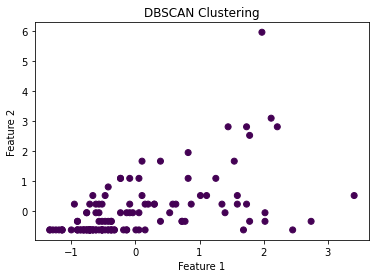

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extracting the same features as above
X = temp_df[temp_df.columns[1:]].to_numpy()

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
cluster_assignments = dbscan.fit_predict(X_scaled)

# Visualize clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


### Conclusion:
There is only one cluster. Thus, we cannot apply silhoutte score to measure the compactness. Furthermore, it shows that the dataset is not seperable using DBScan.